In [4]:
print("hello")

hello


In [ ]:
import clearml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# from tsfresh import extract_features
from sklearn import model_selection
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression

In [3]:
def windows_extracting(ds, data_window_size=30, label_window_size=7):
    """Возвращает список всех промежутков по <data_window_size> строк,
       и список соответствующих последующих промежутков по <label_window_size> строк"""
    # Создание списков, содержащих промежутки данных по <data_window_size> дней
    data_windows = []
    # Всего должно быть len(dataset) - data_window_size + 1 - label_window_size списков; индексация от 0
    for i in range(len(ds) - data_window_size + 1 - label_window_size):
        data_windows.append(ds[i:i + data_window_size])  # exclusive!

    # Создание списков с метками (y) для каждого промежутка, содержащих <label_window_size> последующих дней
    label_windows = []
    for i in range(data_window_size, len(data_windows) + data_window_size):
        label_windows.append(ds[i:i + label_window_size]['<CLOSE>'].values)
    # Проверка, что длины data_windows и label_windows совпадают
    assert len(data_windows) == len(label_windows)

    # Проверка, что последние промежутки не "зажевались"
    assert len(data_windows[-1]) == data_window_size and len(label_windows[-1]) == label_window_size

    return np.array(data_windows), np.array(label_windows)

In [11]:
# Импорт датасетов. Формат даты в исходниках yymmdd преобразуется с помощью parse_dates
df1 = pd.read_csv("DataSources/GC_070904_090320.csv", parse_dates=[0],
                usecols=lambda x: x != '<TIME>', index_col=['<DATE>'])  # , index_col=['<DATE>']
df2 = pd.read_csv("DataSources/GC_090321_140320.csv", parse_dates=[0],
                usecols=lambda x: x != '<TIME>', index_col=['<DATE>'])
df3 = pd.read_csv("DataSources/GC_140321_190320.csv", parse_dates=[0],
                usecols=lambda x: x != '<TIME>', index_col=['<DATE>'])
df4 = pd.read_csv("DataSources/GC_190321_240319.csv", parse_dates=[0],
                usecols=lambda x: x != '<TIME>', index_col=['<DATE>'])
df1.head()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,
2007-09-04,674.7,674.9,674.5,674.9,0
2007-09-05,674.8,685.3,674.4,684.1,884
2007-09-06,683.5,685.5,681.0,685.0,623
2007-09-07,684.0,700.4,684.0,698.0,2004
2007-09-08,697.0,710.0,695.1,704.0,1588


In [14]:
dataset.head()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,
2007-09-04,0.000000,0.000000,0.000066,0.000000,0.000000
2007-09-05,0.000066,0.006806,0.000000,0.006088,0.001399
2007-09-06,0.005816,0.006937,0.004374,0.006683,0.000986
2007-09-07,0.006147,0.016687,0.006362,0.015286,0.003173
2007-09-08,0.014739,0.022970,0.013718,0.019256,0.002514


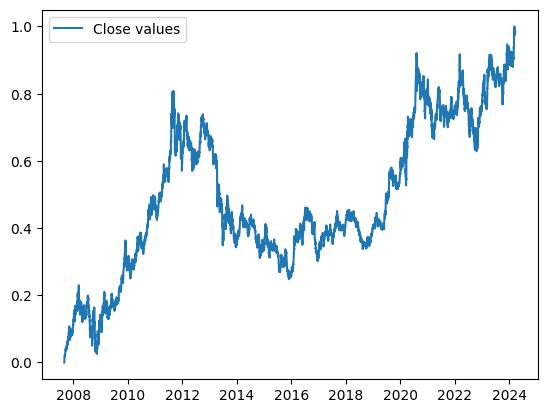

Пример последнего промежутка данных и соответствующих меток:
[[8.78387310e-01 8.79523591e-01 8.79390325e-01 8.85918475e-01
  6.32206017e-02]
 [8.84996695e-01 8.79065506e-01 8.82504970e-01 8.87109582e-01
  1.98158236e-01]
 [8.86252479e-01 9.14730711e-01 8.86083499e-01 9.21453150e-01
  2.29432131e-01]
 [9.20423001e-01 9.13487337e-01 9.15506958e-01 9.19732663e-01
  2.51136261e-01]
 [9.18836748e-01 9.11000589e-01 9.12392313e-01 9.16357861e-01
  2.19976349e-01]
 [9.15399868e-01 9.29782082e-01 9.13320080e-01 9.35944944e-01
  3.12461907e-01]
 [9.36549901e-01 9.66821543e-01 9.39231279e-01 9.46532557e-01
  1.51784852e-01]
 [9.45472571e-01 9.39859957e-01 9.04506296e-01 9.10071466e-01
  4.38618155e-01]
 [9.09253139e-01 9.04980041e-01 8.96752816e-01 9.03057173e-01
  2.68873174e-01]
 [9.02181097e-01 9.02100648e-01 9.03379722e-01 9.05307041e-01
  2.25867017e-01]
 [9.04362194e-01 9.04587396e-01 9.02717031e-01 9.08483325e-01
  2.44808660e-01]
 [9.07600793e-01 8.99024933e-01 8.85487078e-01 8.89425622e-

d:\VSCodeProjects\Gold\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.257e-01, tolerance: 9.199e-03
  model = cd_fast.enet_coordinate_descent(
d:\VSCodeProjects\Gold\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(


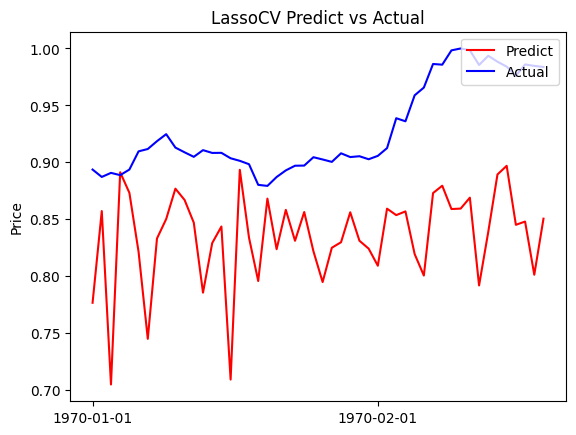

"# Преобразуем названия столбцов в ожидаемый Prophet формат\ndf_prophet = df.rename(columns={'<DATE>': 'ds', '<CLOSE>': 'y'})\n\n# Создаем и обучаем модель Prophet\nmodel = Prophet()\nmodel.fit(df_prophet)\n\n# Создаем фрейм данных для будущих предсказаний (например, на следующие 30 дней)\nfuture = model.make_future_dataframe(periods=30)\n\n# Делаем предсказания\nforecast = model.predict(future)\n\n# Извлекаем некоторые признаки из предсказаний\n# Например, можно извлечь тренд и сезонность\ntrend = forecast['trend']\nseasonality = forecast['yearly']\n\n# Добавляем извлеченные признаки обратно в датасет\ndf['trend'] = trend[:-30]  # Отсекаем предсказания на будущее\ndf['seasonality'] = seasonality[:-30]\n\n# Проверяем обновленный датасет\nprint(df.head())"

In [16]:
# X_train, Y_train, x_test, y_test = model_selection.train_test_split(dataset)
plt.plot(dataset['<CLOSE>'], label="Close values")
plt.legend()
plt.show()
"""features_data = dataset

features_data['<PRICE_CHANGE>'] = dataset['<CLOSE>'] - dataset['<OPEN>']
features_data['<PRICE_RANGE>'] = dataset['<HIGH>'] - dataset['<LOW>']"""

data_windows, label_windows = windows_extracting(dataset, data_window_size=50, label_window_size=50)

print("Пример последнего промежутка данных и соответствующих меток:")
print(data_windows[-1])
print(label_windows[-1])

validation_X, validation_y = data_windows[-1], label_windows[-1]

X_train, y_train = data_windows[:-1], label_windows[:-1]
print("validation_X, validation_y: \n", validation_X, validation_y)
print(len(validation_X), len(validation_y))
print(len(dataset[0:1000]), len(dataset[1000:2000]))


lasso_clf = LassoCV(max_iter=6000, random_state=0)
lasso_clf_feat = lasso_clf.fit(dataset[0:2500], dataset['<CLOSE>'][2500:5000])  # data_windows[:-1], label_windows[:-1]
validate_result(lasso_clf_feat, 'LassoCV', validation_X, validation_y)
"""plt.plot(dataset['<VOL>'], label="Volatility values")
plt.legend()
plt.show()"""

"""extracted_features = extract_features(dataset, column_id='<DATE>')

# Вывод извлеченных признаков на экран
print(extracted_features)
extracted_features.to_csv('DataSources/extracted_features.csv', index=False)"""
